# Process the zscore results from all gene sets 


For figure 3

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

from IPython.display import display

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'sans-serif')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

% matplotlib inline


# Load the PCnet interactome

PCnet downloaded from ndex and parsed to networkx format 
https://ndexbio.org/#/network/f93f402c-86d4-11e7-a10d-0ac135e8bacf

In [2]:
# Load pcnet
Gint = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
print(len(Gint.nodes()))
print(len(Gint.edges()))

19781
2724724


# Load the seed genes

In [3]:
# ------- ASD high confidence genes (established disease genes) -------

HC_genes_temp = pd.read_csv('../data/HC_genes/ASD_HC.tsv',sep='\t',index_col='Unnamed: 0')
ASD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

print(len(ASD_HC))

# ------- High confidence CHD genes (established disease genes) -------

# Load congenital heart defect recurring DNVs (from https://www.nature.com/articles/ng.3970)

HC_genes_temp = pd.read_csv('../data/HC_genes/CHD_HC.tsv',sep='\t',index_col='Unnamed: 0')
CHD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

print(len(CHD_HC))

65
66


# Load the zscore data

In [4]:

num_reps=5000

# -------------- ASD and CHD results --------------
CHD_z = pd.read_csv('../data/z_score_results/z_CHD_'+str(num_reps)+'_repsPCnet_degree_binning.tsv',sep='\t',names=['symbol','z'])
CHD_z.index=CHD_z['symbol']
CHD_z=CHD_z.sort_values('z',ascending=False)

ASD_z = pd.read_csv('../data/z_score_results/z_ASD_'+str(num_reps)+'_repsPCnet_degree_binning.tsv',sep='\t',names=['symbol','z'])
ASD_z.index=ASD_z['symbol']
ASD_z=ASD_z.sort_values('z',ascending=False)

# -------------- DISGENET results --------------


atherosclerosis_z = pd.read_csv('../data/z_score_results/z_Atherosclerosis_5000_reps_degree_binning.tsv',sep='\t',names=['symbol','z'])
atherosclerosis_z.index=atherosclerosis_z['symbol']
atherosclerosis_z=atherosclerosis_z.sort_values('z',ascending=False)

kartagena_z = pd.read_csv('../data/z_score_results/z_Kartagener_5000_reps_degree_binning.tsv',sep='\t',names=['symbol','z'])
kartagena_z.index=kartagena_z['symbol']
kartagena_z=kartagena_z.sort_values('z',ascending=False)



# -------------- ASD GWAS results ----------------
ASD_GWAS_z = pd.read_csv('../data/z_score_results/z_ASD_GWAS_PASCAL_PCnet_1000_reps_degree_binning.tsv',sep='\t',names=['symbol','z'])
ASD_GWAS_z.index=ASD_GWAS_z['symbol']
ASD_GWAS_z=ASD_GWAS_z.sort_values('z',ascending=False)



# How much do the networks overlap?

- Plot the gene overlap in subgraphs

In [5]:
# function to return significant digits in exp form
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def calculate_size_network_overlap(z1,z2,zthresh=3):
    z_merged = z1.join(z2['z'],lsuffix='_1',rsuffix='_2')
    z_combined = z_merged['z_1']*z_merged['z_2']*(z_merged['z_1']>0)*(z_merged['z_2']>0)
    high_z_genes = z_combined[z_combined>=zthresh].index.tolist()
    
    return(len(high_z_genes))

def calculate_expected_overlap(d1,d2,z1,z2,plot=False,zthresh=4,numreps=1000):

    z_d1d2_size=calculate_size_network_overlap(z1,z2,zthresh=zthresh)

    high_z_rand = []
    for r in np.arange(numreps):
        # use permutation shuffling method instead of Fnew comparison
        d1_shuf_genes = z1.index.tolist()
        np.random.shuffle(d1_shuf_genes)
        d1_shuf=z1[:]
        d1_shuf.index=d1_shuf_genes

        d2_shuf_genes = z2.index.tolist()
        np.random.shuffle(d2_shuf_genes)
        d2_shuf=z2[:]
        d2_shuf.index=d2_shuf_genes

        high_z_temp = calculate_size_network_overlap(d1_shuf,d2_shuf,zthresh=zthresh)
        high_z_rand.append(high_z_temp)

    if plot==True:
        sns.distplot(high_z_rand,label='expected network intersection size')
        plt.plot([z_d1d2_size,z_d1d2_size],[0,0.015],label='observed '+d1+'-'+d2+' network intersection size')
        plt.xlabel('size of proximal subgraph, z>='+str(zthresh),fontsize=16)
        plt.legend(fontsize=12)
    return z_d1d2_size,high_z_rand

In [6]:
from scipy.stats import hypergeom
from scipy.stats import norm

z_dict = {'atherosclerosis':atherosclerosis_z,'kartagener':kartagena_z,
          'CHD':CHD_z,'ASD':ASD_z,'ASD_GWAS':ASD_GWAS_z}

# save the num overlap and overlap p-val in dataframes

focal_diseases = ['atherosclerosis','kartagener','CHD','ASD','ASD_GWAS']

network_num_overlap = pd.DataFrame(np.zeros((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_num_overlap.columns = focal_diseases

network_obs_exp = pd.DataFrame(np.zeros((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_obs_exp.columns = focal_diseases

network_pval_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_pval_overlap.columns = focal_diseases

network_exp_mean_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_exp_mean_overlap.columns = focal_diseases

network_exp_std_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_exp_std_overlap.columns = focal_diseases


for i in np.arange(len(focal_diseases)-1):
    for j in np.arange(1+i,len(focal_diseases)):
        d1=focal_diseases[i]
        d2=focal_diseases[j]
        z1=z_dict[d1]
        z2=z_dict[d2]

        # replace hypergeometric with permutation empirical p
        z_d1d2_size,high_z_rand=calculate_expected_overlap(d1,d2,z1,z2,plot=False,numreps=100,zthresh=3)
        ztemp = (z_d1d2_size-np.mean(high_z_rand))/np.std(high_z_rand)
        ptemp = norm.sf(ztemp)
        print(d1+' + '+d2)
        print(z_d1d2_size)
        obs_exp_temp = float(z_d1d2_size)/np.mean(high_z_rand)
        print(obs_exp_temp)
        print(ptemp)
        
        
        network_num_overlap.loc[d1][d2]=z_d1d2_size
        network_num_overlap.loc[d2][d1]=z_d1d2_size

        network_pval_overlap.loc[d1][d2]=ptemp
        network_pval_overlap.loc[d2][d1]=ptemp
        
        network_obs_exp.loc[d1][d2]=obs_exp_temp
        network_obs_exp.loc[d2][d1]=obs_exp_temp
        
        network_exp_mean_overlap.loc[d1][d2]=np.mean(high_z_rand)
        network_exp_mean_overlap.loc[d2][d1]=np.mean(high_z_rand)
        
        network_exp_std_overlap.loc[d1][d2]=np.std(high_z_rand)
        network_exp_std_overlap.loc[d2][d1]=np.std(high_z_rand)
        
        

atherosclerosis + kartagener
139
0.36603992205193026
1.0
atherosclerosis + CHD
586
1.0565030829697473
0.05849882840854005
atherosclerosis + ASD
263
0.4427833055541526
1.0
atherosclerosis + ASD_GWAS
337
0.822633403310062
0.9999223713131392
kartagener + CHD
196
0.7481487136422628
0.999999125315969
kartagener + ASD
295
1.029524673693027
0.2788268947656667
kartagener + ASD_GWAS
200
1.012248203259439
0.43055674698514473
CHD + ASD
844
2.0923198968714365
5.715525029477202e-186
CHD + ASD_GWAS
433
1.5382975699872103
1.5167300340998014e-24
ASD + ASD_GWAS
487
1.6010257084620947
4.166145367077862e-36


In [7]:
# make sure significant overlaps have >0 overlapping genes
network_pval_overlap = np.minimum(network_pval_overlap*(network_num_overlap>0)+(network_pval_overlap+1)*(network_num_overlap==0),1)

display(network_num_overlap)
display(network_pval_overlap)

# network_num_overlap.to_csv('network_num_overlap_z'+str(zthresh)+'.tsv',sep='\t')
# (-np.log(network_pval_overlap)).to_csv('network_pval_overlap_z'+str(zthresh)+'_ATH_PSO_KART.tsv',sep='\t')

,atherosclerosis,kartagener,CHD,ASD,ASD_GWAS
atherosclerosis,0.0,139.0,586.0,263.0,337.0
kartagener,139.0,0.0,196.0,295.0,200.0
CHD,586.0,196.0,0.0,844.0,433.0
ASD,263.0,295.0,844.0,0.0,487.0
ASD_GWAS,337.0,200.0,433.0,487.0,0.0


,atherosclerosis,kartagener,CHD,ASD,ASD_GWAS
atherosclerosis,1.000000,1.000000,5.849883e-02,1.000000e+00,9.999224e-01
kartagener,1.000000,1.000000,9.999991e-01,2.788269e-01,4.305567e-01
CHD,0.058499,0.999999,1.000000e+00,5.715525e-186,1.516730e-24
ASD,1.000000,0.278827,5.715525e-186,1.000000e+00,4.166145e-36
ASD_GWAS,0.999922,0.430557,1.516730e-24,4.166145e-36,1.000000e+00


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


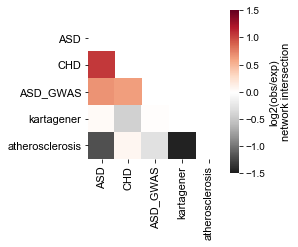

In [8]:
dlist = ['ASD','CHD','ASD_GWAS','kartagener','atherosclerosis']
plt.figure(figsize=(3,3))
mask = np.triu(np.ones_like(network_obs_exp.loc[dlist][dlist], dtype=np.bool))
hfig=sns.heatmap(np.log2(network_obs_exp.loc[dlist][dlist]),cmap='RdGy_r',
                 vmin=-1.5,vmax=1.5,square=True,cbar_kws={'label':'log2(obs/exp)\nnetwork intersection'},
                mask=mask)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)



hfig.figure.axes[-1].yaxis.label.set_size(11)
# plt.savefig('../../../manuscript/figures_1911/Figure3/Figure3_final assets/fold_change_heatmap_network_intersection.png',
#            dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Figure3/Figure3_final assets/fold_change_heatmap_network_intersection.svg',
#            dpi=300,bbox_inches='tight')

(0, 950)

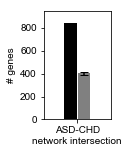

In [9]:
dpairlist=[('ASD','CHD')]

obs_temp_list = []
exp_temp_list=[]
exp_std_list = []
xlabel_list=[]
high_zrand_list = []
for dpair in dpairlist:
    d1=dpair[0]
    d2=dpair[1]
    z1=z_dict[d1]
    z2=z_dict[d2]
    # run the function again to get the distribution
#     z_d1d2_size,high_z_rand=calculate_expected_overlap(d1,d2,z1,z2,plot=False,numreps=100,zthresh=3)
#     high_zrand_list.append(high_z_rand)
    obs_temp_list.append(network_num_overlap.loc[d1][d2])
    exp_temp_list.append(network_exp_mean_overlap.loc[d1][d2])
    exp_std_list.append(network_exp_std_overlap.loc[d1][d2])
    xlabel_list.append(d1+'-'+d2)
    
    
plt.figure(figsize=(1.2,2))
plt.bar(np.arange(len(obs_temp_list))-.2,obs_temp_list,width=.38,color='black',label='observed')
plt.bar(np.arange(len(exp_temp_list))+.2,exp_temp_list,width=.38,color='gray',label='expected')
plt.errorbar(np.arange(len(exp_temp_list))+.2,exp_temp_list,exp_std_list,fmt='none',color='k',capsize=4)
# plt.violinplot(high_zrand_list,positions=np.arange(len(exp_temp_list))+.2)
plt.ylabel('# genes',fontsize=10)
plt.xticks(np.arange(len(obs_temp_list)),['ASD-CHD\nnetwork intersection'],fontsize=10,rotation='horizontal')
plt.yticks(fontsize=10)
plt.xlim([-1,1])
plt.ylim([0,950])
# plt.legend(loc='upper right',fontsize=11)
# plt.savefig('../../../manuscript/figures_1911/Figure2/Figure2_final assets/num_net_intersection_genes_ASD_CHD.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Figure2/Figure2_final assets/num_net_intersection_genes_ASD_CHD.svg',dpi=300,bbox_inches='tight')

In [10]:
network_exp_std_overlap

,atherosclerosis,kartagener,CHD,ASD,ASD_GWAS
atherosclerosis,1.000000,16.850887,19.993609,18.439878,19.209487
kartagener,16.850887,1.000000,13.802159,14.428735,13.831977
CHD,19.993609,13.802159,1.000000,15.162309,14.915415
ASD,18.439878,14.428735,15.162309,1.000000,14.635833
ASD_GWAS,19.209487,13.831977,14.915415,14.635833,1.000000
